In [2]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os
from scipy.optimize import minimize

In [3]:
N = 5000  # Run size
n = 1000  # Burn-in size
a = [0.8, 0.2, 0.5]  # Parameters of the GARCH model: omega, alpha, beta

def garch_11(parameters, N):
    r = np.zeros(N)  # r corresponds to the GARCH process
    h = np.zeros(N)  # h corresponds to the volatility: h=sigma^2

    # We define the initial values of r and h
    r[0] = 0.1
    h[0] = 0.01

    WN = np.random.normal(0, 1, N)  # noise follows a Normal(0,1)

    for i in range(1, N):
        h[i] = parameters[0] + parameters[1] * r[i - 1] ** 2 + parameters[2] * h[i - 1]
        r[i] = np.sqrt(h[i]) * WN[i]

    return r, h

# Simulate GARCH process with original parameters
r_garch, h_garch = garch_11(a, N)

print(r_garch)

[ 0.1        -0.2792098  -0.44532351 ... -0.15611927 -0.28079187
 -0.49115396]


In [4]:
# With control variate
def garch_11_with_cv(a, N):
    # Simulation parameters
    n_burn = 1000  # Burn-in period
    n_sample = N + n_burn  # Total number of observations
    c = np.array([1.0, 0.5])  # Control variate coefficients

    # Initialize arrays
    r = np.zeros(n_sample)
    h = np.zeros(n_sample)

    # Set initial values
    r[0] = np.sqrt(h[0]) * norm.rvs()
    h[0] = a[0] / (1 - a[1] - a[2])

    # Burn-in period
    for t in range(1, n_burn):
        h[t] = a[0] + a[1] * r[t-1]**2 + a[2] * h[t-1]
        r[t] = np.sqrt(h[t]) * norm.rvs()

    # Compute control variate
    cv = np.zeros(n_sample)
    cv[1:] = h[:-1]

    # Linear regression to estimate control variate coefficients
    X = np.column_stack([np.ones(n_burn), cv[:n_burn]])
    y = r[:n_burn]
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    c_opt = reg.coef_ # Coefficients of the control variate function f(x) = c1 + c2*x

    # Generate final sample with control variate
    for t in range(n_burn, n_sample):
        h[t] = a[0] + a[1] * r[t-1]**2 + a[2] * h[t-1]
        r[t] = np.sqrt(h[t]) * norm.rvs() - c_opt[0] - c_opt[1] * cv[t]

    return r[n_burn:], h[n_burn:], c_opt

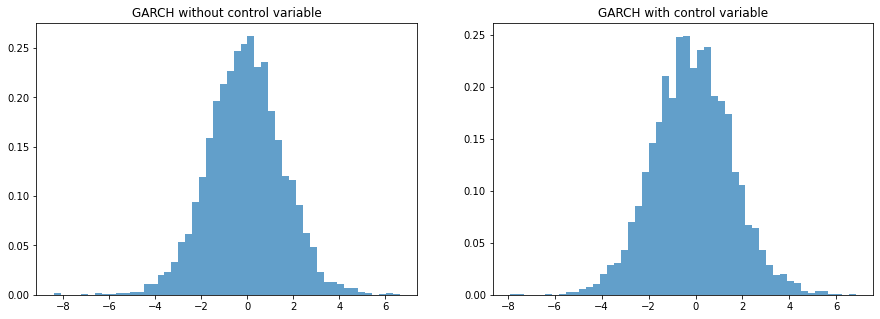

In [5]:
# Simulate GARCH process with control variate
r_garchZV, h_garchZV, c_opt = garch_11_with_cv(a, 4000)

# Plot distributions of results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(r_garch.flatten(), bins=50, alpha=0.7, density=True)
ax[0].set_title('GARCH without control variable')
ax[1].hist(r_garchZV.flatten(), bins=50, alpha=0.7, density=True)
ax[1].set_title('GARCH with control variable')
plt.show()

In [ ]:
#ZV-MCMC

def g0_cv(r, h):
    return -0.5 * np.log(h) - 0.5 * ((r-c_opt[0]-c_opt[1]*h)**2 / h)  # Normal law because r_{t}|F_t-1 follow N(c[0]+c[1]*h_t,h_t)

def g_cv(x, data, h_initial):
    h = h_initial  # How to fix h? Proposition: max g0_cv initial
    LL = g0_cv(data[0]-c_opt[0]-c_opt[1]*h, h)  # density is initialized with our first simulated data with control variate

    for i in range(1, len(data)):
        h = x[0] + x[1] * (data[i-1]-c_opt[0]-c_opt[1]*h)**2 + x[2] * h
        LL += g0_cv(data[i]-c_opt[0]-c_opt[1]*h, h)

    return LL

#In this function, r represents the simulated data with the control variate term subtracted,which is (r-c[0]-c[1]*h) in the g0_cv function. 
#This function returns the loglikelihood of the GARCH process with control variate, which we can use as the objective function in the ZV-MCMC algorithm.

def optimize_h(data):
    fun = lambda h: -g0_cv(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garchZV)

M = 3000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.9, 0.1, 0.4] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.01  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=1.5516117635447455 #initial h for the density computation

while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = g_cv(Y, data = r_garch, h_initial=h_initial) - g_cv(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)
        
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

B = 600  # amount of burn-in

# We plot the density of the sample for each parameters :

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

#We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

def varfact(x): # function to get a variance factor used to obtain true standard error (because of the serial correlationn)
    acf_vals = acf(x, nlags=None, fft=True)  # acf comutation
    var_factor = 2 * np.sum(acf_vals) - 1  # variance factor computation
    return var_factor

# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")